In [1]:
import model as my_model
import dataloader as my_dataset
import train as my_train
from res_AE import ResNetAE  # res_ae = ResNetAE()

import random

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
import torch.nn as nn
from glob import glob

In [2]:
#plt.style.use('ggplot')
plt.style.use('classic')
# 用 SGD 優化 試試

In [65]:
good_bad_dataset = my_dataset.QR_good_bad_dataset("./data", image_size=256, image_channels=1)

# split dataset
my_dataloader, my_val_dataset, my_test_dataset = random_split(good_bad_dataset, [0.7, 0.2, 0.1],
                                                              generator=torch.Generator().manual_seed(42))
#my_dataloader, my_val_dataset, _ = random_split(good_bad_dataset, [7, 3, 720])  # for fast test

my_dataloader = DataLoader(good_bad_dataset, batch_size=8, drop_last=True, pin_memory=False)
my_val_dataloader = DataLoader(my_val_dataset, batch_size=4, drop_last=True, pin_memory=False)
r, c = 3, 3
assert r * c <= len(my_test_dataset)
test_dataloader = DataLoader(my_test_dataset, batch_size=r*c, drop_last=False, pin_memory=False)

# net = my_model.Autoencoder()
# net.load_state_dict(torch.load("./1202_1211_59_e18999.pt"))

net = ResNetAE(input_shape=(256,256,1))
net.load_state_dict(torch.load("1225_1027_07_e400.pt"))
net.cuda();

In [66]:
# 推理模式
net.eval();

In [15]:
# test 不要做這個，要訓練才設定。
torch.manual_seed(0)

In [ ]:
#
net = my_train.train(net, my_dataloader, my_val_dataloader, epoches=20000, lr=1e-5)

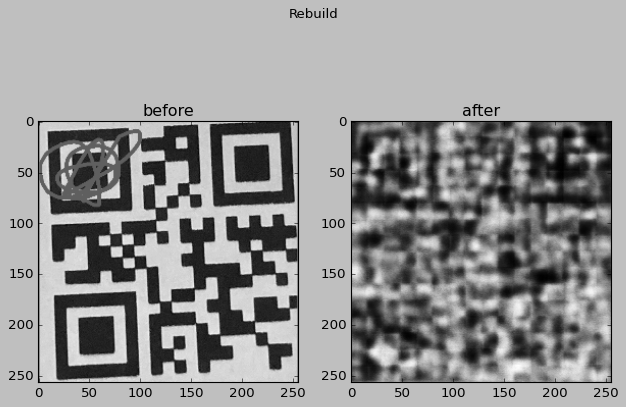

In [40]:
# 使用測試圖片
test_img = "test.png"

from util import pad_2_square
import cv2
from pathlib import Path
assert Path(test_img).exists()

img_gray = cv2.imread(test_img, cv2.IMREAD_GRAYSCALE)

test_img = pad_2_square(img_gray, export_size=256).reshape((256,256,1))
test_img_batch = torch.tensor(test_img.reshape((1,1,256,256))).cuda().float()/255.0

net.eval()

after_net = net(test_img_batch)
after_img = after_net.reshape((256,256,1)).detach().cpu().numpy()

# bad image
test_img

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Rebuild')
#
ax1.set_title('before')
ax1.imshow(test_img, cmap=plt.cm.gray)
#
ax2.set_title('after')
ax2.imshow(after_img, cmap=plt.cm.gray)
#
plt.tight_layout()
plt.show()

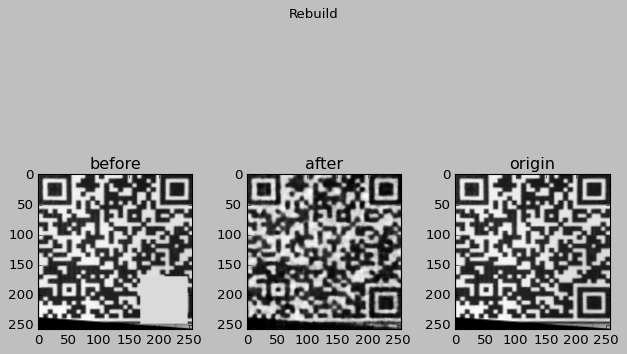

In [67]:
net.eval()

_pick_idx = random.randint(0, len(my_test_dataset))
# bad image
test_batch = my_test_dataset[_pick_idx][1].reshape(1, 1, 256, 256)
test_origin = my_test_dataset[_pick_idx][0].reshape(1, 1, 256, 256)
# show bad batch
_test_batch_show = np.array(test_batch.reshape(256, 256, 1))
plt.imshow(_test_batch_show, cmap=plt.cm.gray)
fig1 = plt.gcf()
fig1.savefig("before.png")

output_batch = net(test_batch.cuda().float()/255.0)
# show output_batch batch
_output_show = output_batch.reshape(256, 256, 1).detach().cpu().numpy()*255.0
plt.imshow(_output_show, cmap=plt.cm.gray)
fig2 = plt.gcf()
fig2.savefig("after.png")

plt.close()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Rebuild')
#
ax1.set_title('before')
ax1.imshow(_test_batch_show, cmap=plt.cm.gray)
#
ax2.set_title('after')
ax2.imshow(_output_show, cmap=plt.cm.gray)
#
ax3.set_title('origin')
test_origin = np.array(test_origin.reshape(256, 256, 1))
#test_origin.reshape(256, 256, 1).detach().cpu().numpy()*255.0

ax3.imshow(test_origin, cmap=plt.cm.gray)
#
plt.tight_layout()
plt.show()

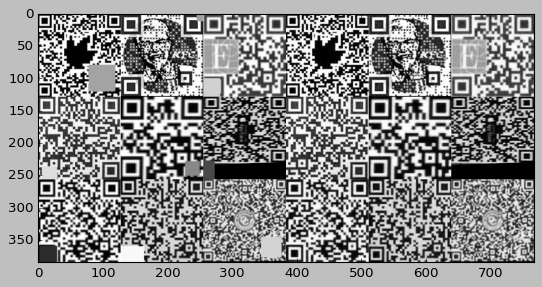

In [25]:
plt.imshow(my_train.make_test_view(net, test_dataloader,r,c, sub_size=128, normalization=True), cmap='gray')
plt.savefig("preview.jpg", dpi=300)


In [28]:
import glob
from PIL import Image
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*")]
    
    frame_one = frames[0]
    frame_one.save("./preview.gif", format="GIF", append_images=frames,
               save_all=True, duration=2, loop=1)
#
make_gif(f"H:\我的雲端硬碟\ColabNotebooks\Runnings-save_1225_0832_01\preview_step")

In [ ]:
import imageio
from glob import glob
images = []
for filename in glob("H:\我的雲端硬碟\ColabNotebooks\Runnings-save_1225_0832_01\preview_step\*.jpg"):
    images.append(imageio.v2.imread(filename))
kargs = { 'duration': 5 }
imageio.mimsave('./preview.gif', images, "GIF", kargs)

In [29]:
print("")

In [14]:
import os

In [17]:
os.getcwd()

'E:\\Git\\zjpj\\colab'

In [1]:
# 繪製 loss 圖表 by txt
#
loss_fn = "./loss_recoder_1225_0832_01.txt"

with open(loss_fn, mode='r', encoding='utf-8') as  f:
    lines = f.readlines()[2:]

tloss_list = []
vloss_list = []
lr_list = []
for line in lines:
    tloss, vloss, lr = line.rstrip().split(',')
    tloss_list.append(tloss)
    vloss_list.append(vloss)
    lr_list.append(lr)

import numpy as np
import matplotlib.pyplot as plt
tloss_list = np.array(tloss_list, dtype=np.float64)
vloss_list = np.array(vloss_list, dtype=np.float64)
lr_list = np.array(lr_list, dtype=np.float64)

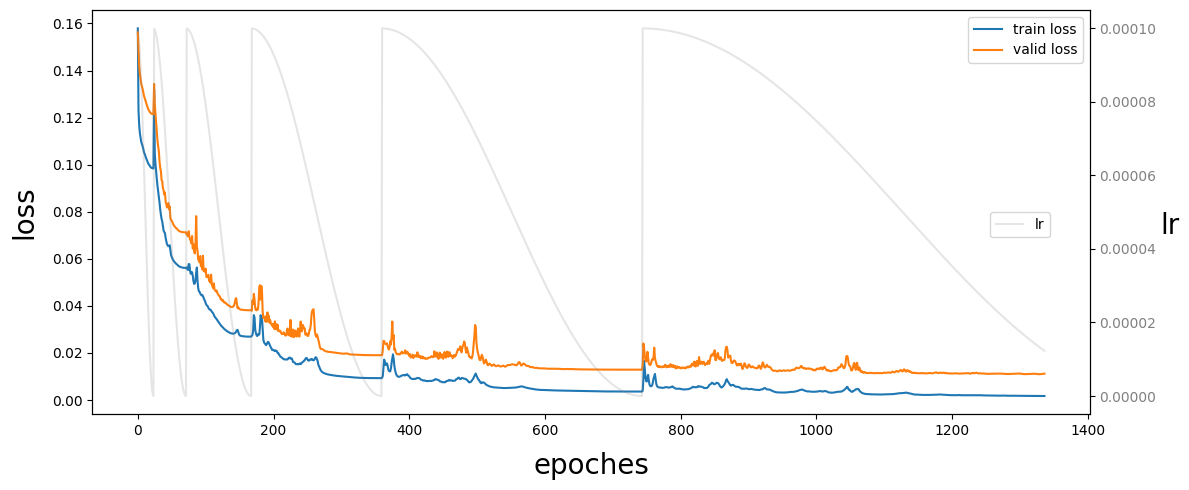

In [6]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(tloss_list, label='train loss')
ax.plot(vloss_list, label='valid loss')
plt.xlabel('epoches', labelpad=10, fontsize=20)
plt.ylabel('loss', labelpad=10, fontsize=20)
ax.tick_params(axis='y')

ax.legend()

ax2 = ax.twinx()

ax2.plot(lr_list, color='gray', alpha=0.2, label='lr')
ax2.tick_params(axis='y', labelcolor='gray')
plt.ylabel('lr', labelpad=10, fontsize=20, rotation=0)

plt.legend(bbox_to_anchor=(0.9, 0.5), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig("123.png", dpi=600)
plt.show()



In [ ]:
# for validation dataloader
# mse = nn.MSELoss()

# for pt in glob("weights/*"):
#     net = ResNetAE(input_shape=(256,256,1))
#     net.load_state_dict(torch.load(pt))
#     #net.cuda()
#     net.eval()
#     loss_tmp = 0
#     for batch_idx, data_good_bad in enumerate(my_val_dataloader):
#         good, bad = data_good_bad
#         good = good.float()
#         bad = bad.float()
#         loss = mse(net(bad), good)
        
#         loss_tmp += loss
#     loss_tmp /= batch_idx
#     print(f"{pt}: ", loss_tmp)
#     break
    
    

In [6]:
# resnet visualization
import hiddenlayer as hl
import torchvision.models

In [ ]:
# Build HiddenLayer graph
# Jupyter Notebook renders it automatically

dummy = torch.zeros([4, 1, 256, 256]).cuda().float()


In [11]:

good_dummy_batch, bad_dummy_batch = next(iter(my_val_dataloader))
good_dummy_batch = good_dummy_batch.cuda().float() / 255.0

# Build HiddenLayer graph
# Jupyter Notebook renders it automatically
graph = hl.build_graph(net, dummy)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('rnn_hiddenlayer', format='png')
print("printOK")

NameError: name 'graph' is not defined

In [53]:
transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

graph = hl.build_graph(net, good_dummy_batch, transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('rnn_hiddenlayer', format='png')

AttributeError: module 'torch.onnx' has no attribute '_optimize_trace'

In [52]:
torch.onnx._optimize_graph 

<function torch.onnx.utils._optimize_graph(graph: '_C.Graph', operator_export_type: '_C_onnx.OperatorExportTypes', _disable_torch_constant_prop: 'bool' = False, fixed_batch_size: 'bool' = False, params_dict=None, dynamic_axes=None, input_names=None, module=None)>